In [1]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array


In [2]:
#A = array([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0])
A = array([0,1,1,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,1,1])
#B = A[::-1] # not sure if this is the way to do it (should it be just each sample that is reversed, or the whole sequence?)

#A = A.reshape((5, 4, 1))
# for x in A:
#     C = A[::-1] 

time_steps = 4
n_features = 1
#n_samples = A.shape[0]
#C = np.flip(A,1)


In [3]:

def overlapping_window (window_size,overlap,seq): # overlap 1 is max. larger number would be less overlap
 
    seq = array([seq[i : i + window_size] for i in range(0, len(seq), overlap)]) 
    correct = [len(x)==window_size for x in seq]
    seq = seq[correct]
    seq = np.stack(seq, axis=0 )
    seq = seq.reshape(-1,window_size,1)

    return seq


In [8]:
A_window = overlapping_window(4,2,A)
print(A_window.shape)
n_samples = A_window.shape[0]
print(n_samples)


(9, 4, 1)
9


In [5]:
# time_steps = 40
# n_features = 64
# 64*40 = 2560 output shape??

lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08)

AutoEncoder = Sequential()

# Encoder
AutoEncoder.add(Dense(256, activation='tanh', input_shape=(time_steps,n_features)))
AutoEncoder.add(Dropout(0.2))

AutoEncoder.add(LSTM(128, return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
AutoEncoder.add(LSTM(128, return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
# Decoder
AutoEncoder.add(LSTM(128, return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
AutoEncoder.add(LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))

AutoEncoder.add(Dense(256, activation= 'sigmoid'))
AutoEncoder.add(Dense(1, activation= 'sigmoid')) # they don't mention this in the article but dimensions are wrong otherwise

AutoEncoder.compile(optimizer='adam', loss='binary_crossentropy')
AutoEncoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4, 256)            512       
_________________________________________________________________
dropout (Dropout)            (None, 4, 256)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 4, 128)            197120    
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
dense_1 (Dense)              (None, 4, 256)            3

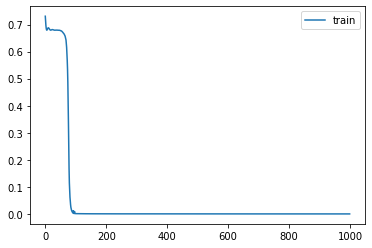

In [9]:
model = AutoEncoder
es= EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)

history = model.fit(A_window, A_window, epochs=1000, verbose=0, shuffle=False,batch_size=n_samples)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [10]:
output = AutoEncoder.predict(A_window) #  Much better when i don't reverse the sequences? reversed incorrectly?
print(output)
print(output.shape)

[[[1.2522936e-04]
  [9.9987435e-01]
  [9.9989957e-01]
  [3.5602118e-06]]

 [[9.9989343e-01]
  [6.6380248e-06]
  [9.9988598e-01]
  [4.7716467e-06]]

 [[9.9989343e-01]
  [6.6380248e-06]
  [6.1857027e-06]
  [2.8600830e-06]]

 [[1.2522936e-04]
  [1.3947010e-05]
  [5.9488966e-06]
  [3.9616484e-06]]

 [[1.2522936e-04]
  [1.3947010e-05]
  [9.9981093e-01]
  [9.9989963e-01]]

 [[9.9989343e-01]
  [9.9989951e-01]
  [9.9989963e-01]
  [2.3557363e-06]]

 [[9.9989343e-01]
  [6.6380248e-06]
  [6.1856972e-06]
  [9.9987495e-01]]

 [[1.2522936e-04]
  [9.9987435e-01]
  [8.2043825e-06]
  [3.7635368e-06]]

 [[1.2522936e-04]
  [1.3947010e-05]
  [9.9981093e-01]
  [9.9989963e-01]]]
(9, 4, 1)


In [11]:
output2 = AutoEncoder.predict(A_window[None,1,:,:])


print(output2)
print(output2.shape)

[[[9.9989343e-01]
  [6.6380248e-06]
  [9.9988598e-01]
  [4.7716467e-06]]]
(1, 4, 1)


In [12]:
output[output<0.5] = 0
output[output>0.5] = 1
print(output)

[[[0.]
  [1.]
  [1.]
  [0.]]

 [[1.]
  [0.]
  [1.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [0.]]

 [[1.]
  [0.]
  [0.]
  [1.]]

 [[0.]
  [1.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [1.]]]
